# Code to test the proof
This code is just to get some simple examples together for gaining intuition on the proof for BAL. 

Things learned
1. The WLM condition seems to pick up points on the decision boundary
2. Applying non-linearities or (not tested) some weighting to the acquisition values and WLM condition could lead to good results where WLM's are LM's. 

Intuition:
1. The decision boundary is a thin band, but the nearest neighbors are drawn from a "ball." When we do the WLM condition, we are doing a weighted average over the ball. A point with high acquisition value will be greater than most of the points in the ball so even if it isn't a LM, it will still satisfy the WLM condition. Points along the decision boundary have high acquisition value with uncertainty sampling. Therefore, the WLM condition will just pick up on points along the boundary. 
2. We can get around this averaging thing by weighting how much the acquisition value counts for. We want the WLM condition to pick up on very high acquisition values, but ignore intermediate ones. If we apply a non-linearity, we can make this defition empirically align with LM (ie. $(L f(A))_i >= 0$ if and only if $x_i$ is a LM). However, these non-linearities will give large gradients in the theoretical calculations. More theory is needed, but we may be able to strengthen the WLM condition. 


**Can also change constant. May interact with the BAL process and constant may have to change...**

In [1]:
import graphlearning.active_learning as al
import graphlearning as gl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import timeit
import batch_active_learning as bal
import scipy as sp

## Make simple dataset

In [2]:
np.random.seed(123)
spread_dist = 5
X, labels = datasets.make_blobs(n_samples=600, n_features=2, random_state=123, 
                                centers = [[0, 0], [spread_dist, 0], [0, spread_dist]])

In [3]:
#plt.scatter(X[:, 0], X[:, 1], c=labels)
#plt.show()

## Make graph learning objects

In [4]:
knn_num = 20
knn_data = gl.weightmatrix.knnsearch(X,knn_num,similarity='euclidean')

W = gl.weightmatrix.knn(X,knn_num, knn_data=knn_data, kernel='gaussian')
G = gl.graph(W)

In [5]:
assert G.isconnected()

In [6]:
train_ind = gl.trainsets.generate(labels, rate=1)
coreset = bal.coreset_dijkstras(G, .5, data = X, density_info = (True, .2, 1.0), initial=list(train_ind));

## Functions

In [48]:
#Make sure to convert csr_matrix to ndarray. It implicitly was doing csr_matrix -> np.matrix
def get_WLM(W, acq_vals, tol=1e-3):
    mat = sp.sparse.csr_matrix.toarray(W)
    tmp = np.sum(mat, axis=1)
    out = (np.diag( np.sum(mat, axis=1) ) - mat) @ acq_vals
    return out > tol

def get_Lap_mat(W):
    mat = sp.sparse.csr_matrix.toarray(W)
    tmp = np.sum(mat, axis=1)
    out = (np.diag( np.sum(mat, axis=1) ) - mat)
    return out

def compute_entropy(u):
    #u is shape (n, c)
    tmp = np.log(np.maximum(u, 1e-5))
    return - np.sum(u * tmp, axis=1)

## Testing

In [8]:
model = gl.ssl.laplace(W, reweighting='poisson')

acq = al.uncertainty_sampling()
act = al.active_learning(W, train_ind, labels[train_ind], eval_cutoff=200)

u = model.fit(act.current_labeled_set, act.current_labels) # perform classification with GSSL classifier

act.candidate_inds = np.setdiff1d(act.training_set, act.current_labeled_set)
acq_vals = acq.compute_values(act, u)

modded_acq_vals = np.zeros(len(X))
modded_acq_vals[act.candidate_inds] = acq_vals

In [9]:
u = model.fit(train_ind, labels[train_ind])
x = np.argmax(u, axis=1)

In [10]:
#plt.scatter(X[:, 0], X[:, 1], c = x)
#plt.show()

In [11]:
is_WLM = get_WLM(W, modded_acq_vals)

In [12]:
np.all(is_WLM)

False

In [13]:
#plt.scatter(X[:, 0], X[:, 1], c = is_WLM)
#plt.show()

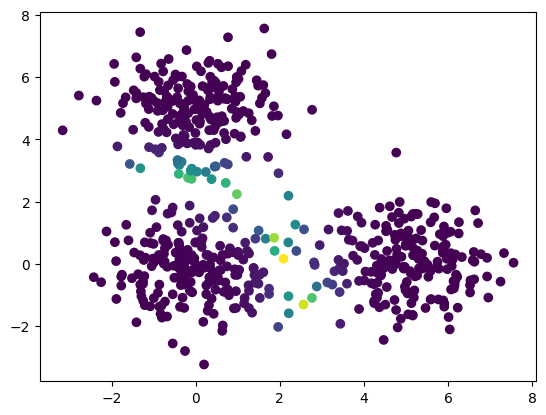

In [28]:
#plt.scatter(X[:, 0], X[:, 1], c = modded_acq_vals)
#plt.show()

## Adding in non-linearities

In [15]:
non_linear_acq_vals = 1 / (1-modded_acq_vals)
is_WLM = get_WLM(W, non_linear_acq_vals)

In [16]:
np.all(is_WLM)

False

In [17]:
is_WLM.shape

(600,)

In [18]:
#plt.scatter(X[:, 0], X[:, 1], c = is_WLM)
#plt.show()

## Laplacian and classification vs Acquisition
We have the equation
$$U_N^* = U^* - \gamma^{-2} L_N^{-1} P_N^T (P_N U^* - Y^N)$$
We need some easier functions to apply to this for detecting LM's. Maybe this theory will approximately translate. I was thinking about the Laplacian since it measures some kind of second derivative. 

Ok. At the boundary, we have lots of change in the classifications. I think this should correspond to having the classification have a large derivative, but be flat in that region. This should happen for multiple variables. 

In [19]:
mat = get_Lap_mat(W)

In [20]:
LU = mat @ u

In [21]:
c1 = LU[:, 0]

In [23]:
c1 = (c1-np.min(c1)) / (np.max(c1) - np.min(c1) + 1e-3)

In [36]:
c2 = LU[:, 1]
c2 = (c2-np.min(c2)) / (np.max(c2) - np.min(c2) +1e-3)

In [49]:
c3 = compute_entropy(u)

In [32]:
LM_batch, _, _ = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=1, method='Laplace',
                           display=False, use_prior=False, al_mtd='local_max', debug=False,
                           acq_fun='uc', batchsize=10)
LM_batch = np.setdiff1d(LM_batch, coreset)

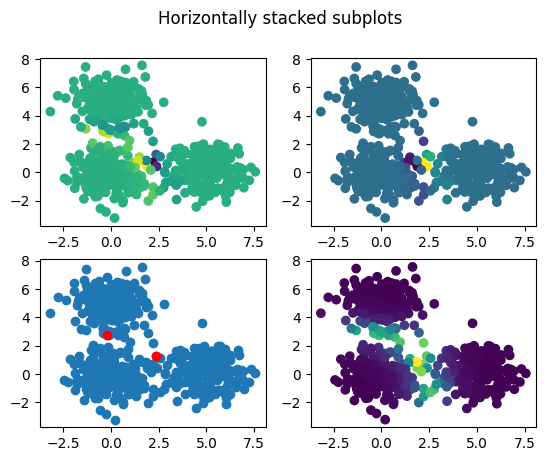

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Horizontally stacked subplots')

ax1.scatter(X[:, 0], X[:, 1], c = c1)
#ax2.plot(x, -y)
#plt.
#plt.colorbar()
#plt.show()

ax2.scatter(X[:, 0], X[:, 1], c = c2)

ax3.scatter(X[:,0], X[:,1])
ax3.scatter(X[LM_batch,0], X[LM_batch,1], c='r')

ax4.scatter(X[:, 0], X[:, 1], c = c3)
#ax4.colorbar()

plt.show()

In [70]:
np.min(modded_acq_vals)
#np.max(modded_acq_vals)

0.0

## Now doing some steps and looking at local maxes

In [25]:
num_points = 2000
X = np.random.uniform(size = (num_points, 2))
labels = np.zeros(num_points, dtype=int)
labels[X[:, 1] - 3*(X[:, 0]-.5)**2 < .2] = 1
W = gl.weightmatrix.knn(X, 20, kernel = 'distance')
G = gl.graph(W)
train_ind = []

coreset = bal.coreset_dijkstras(G, .5, data = X, density_info = (True, .2, 1.0), initial=list(train_ind));

model = gl.ssl.laplace(W, None, reweighting='poisson')
acq = al.uncertainty_sampling()
act = al.active_learning(W, coreset, labels[coreset], eval_cutoff=min(200, len(X) // 2))
u = model.fit(act.current_labeled_set, act.current_labels)  # perform classification with GSSL classifier

act.candidate_inds = np.setdiff1d(act.training_set, act.current_labeled_set)
acq_vals = acq.compute_values(act, u)

modded_acq_vals = np.zeros(len(X))
modded_acq_vals[act.candidate_inds] = acq_vals

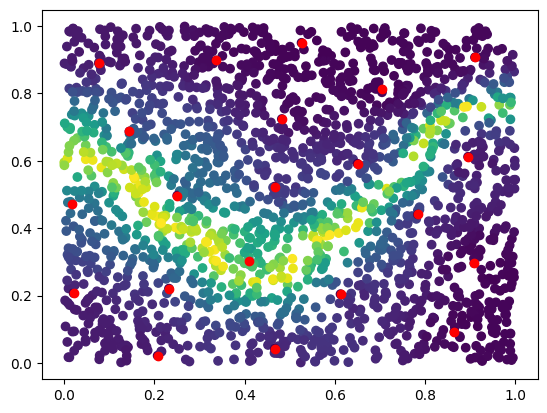

In [26]:
fig1 = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='r')
plt.show()

In [29]:
LM_batch, _, _ = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=1, method='Laplace',
                           display=False, use_prior=False, al_mtd='local_max', debug=False,
                           acq_fun='uc', batchsize=10)
LM_batch = np.setdiff1d(LM_batch, coreset)

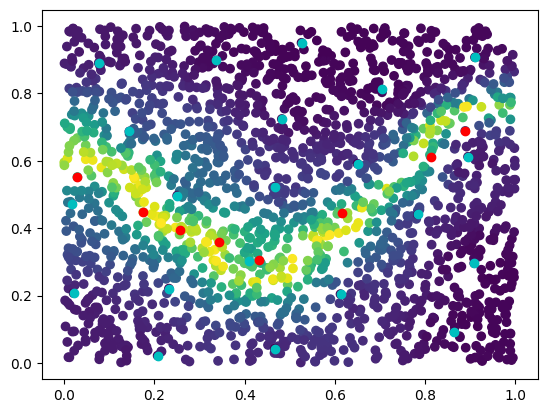

In [30]:
plt.scatter(X[:, 0], X[:, 1], c = modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='c')
plt.scatter(X[LM_batch, 0], X[LM_batch, 1], c='r')
plt.show()

In [31]:
#Now lets only take 4 of the points
new_batch = LM_batch[:4]

u = model.fit(act.current_labeled_set, act.current_labels) # perform classification with GSSL classifier
#query_points = act.select_query_points(acq, u, oracle=None) # return this iteration's newly chosen points
query_labels = labels[new_batch] # simulate the human in the loop process
act.update_labeled_data(new_batch, query_labels) # update the active_learning object's labeled set

In [43]:
mid = np.concatenate((new_batch, np.array(coreset)))
new_LM, _, _ = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=1, method='Laplace',
                           display=False, use_prior=False, al_mtd='local_max', debug=False,
                           acq_fun='uc', batchsize=10)
new_LM = np.setdiff1d(new_LM, mid)

In [45]:
print(new_LM)
print(LM_batch[4:])

[ 793  925 1700 1877]
[ 793  925 1700 1877]


In [46]:
act.candidate_inds = np.setdiff1d(act.training_set, act.current_labeled_set)
acq_vals = acq.compute_values(act, u)

modded_acq_vals = np.zeros(len(X))
modded_acq_vals[act.candidate_inds] = acq_vals

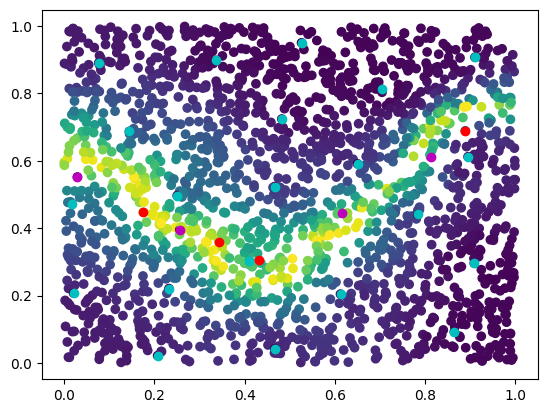

In [49]:
plt.scatter(X[:, 0], X[:, 1], c = modded_acq_vals)
plt.scatter(X[coreset, 0], X[coreset, 1], c='c')
plt.scatter(X[LM_batch[:4], 0], X[LM_batch[:4], 1], c='m')
plt.scatter(X[new_LM, 0], X[new_LM, 1], c='r')
plt.show()

In [51]:
#_, _, _ = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=3, method='Laplace',
#                           display=True, use_prior=False, al_mtd='local_max', debug=False,
#                           acq_fun='uc', batchsize=5)